In [1]:
from cleanfid.inception_pytorch import fid_inception_v3

inception_v3 = fid_inception_v3()
_ = inception_v3.eval()

/home/ubuntu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Library code for trajectory visualization

In [81]:
from typing import Tuple


class TrajectorySet:
    def __init__(self, embeddings):
        """
        Managing a set of trajectories, each of which is a sequence of embeddings.

        Parameters
        ----------
        embeddings: (n_timesteps, n_samples, *embedding_dims). This assumes
            the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
            With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        """
        self.embeddings = embeddings
        self.embeddings_2d = None
    
    def run_tsne(self, n_components: int = 2, seed: int = 0, **kwargs):
        """Run t-SNE on the embeddings.
        """
        print(f"Running t-SNE on {self.embeddings.shape} embeddings...")
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=n_components, random_state=seed, **kwargs)
        flattened_embeddings = self.embeddings.reshape(-1, self.embeddings.shape[-1])
        flattened_embeddings_2d = tsne.fit_transform(flattened_embeddings)
        self.embeddings_2d = flattened_embeddings_2d.reshape(self.embeddings.shape[0], self.embeddings.shape[1], -1)
        print(f"t-SNE done. Shape of 2D embeddings: {self.embeddings_2d.shape}")
        return self.embeddings_2d
    
    def plot_trajectories(
            self,
            n: int = 10,
            show_figure: bool = False,
            noise_color: Tuple[float, float, float] = (0, 0, 1),  # blue
            data_color: Tuple[float, float, float] = (1, 0, 0),  # red
            figsize: tuple = (6, 6),
            with_ticks: bool = False,
            tsne_seed: int = 0,
            **kwargs):
        """Plot trajectories of some selected samples.

        This assumes the first dimension is time. And it is ordered from t=0 to t=n_timesteps-1.
        With t=0 representing the clean data and t=n_timesteps-1 representing the noise.

        Parameters
        ----------
        n: int
            number of samples to plot
        figsize: tuple
            figure size
        kwargs:
            other keyword arguments for matplotlib.pyplot.scatter
        """
        import numpy as np
        import matplotlib.pyplot as plt

        colors = []
        for t in range(self.embeddings.shape[0]):
            # interpolate between noise_color and data_color
            factor = t / (self.embeddings.shape[0] - 1)
            colors.append(np.array(noise_color) * factor + np.array(data_color) * (1 - factor))
        colors = np.array(colors)
        
        if self.embeddings_2d is None:
            if self.embeddings.shape[2] == 2:
                self.embeddings_2d = self.embeddings
            else:
                self.embeddings_2d = self.run_tsne(seed=tsne_seed)

        traj = self.embeddings_2d[:, :n, :]
        plt.figure(figsize=figsize)
        plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="red")  # real
        plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")  # noise
        plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.5, alpha=0.7, c=colors.repeat(n, axis=0))  # "olive"
        plt.plot(traj[:, :n, 0], traj[:, :n, 1], c="olive", alpha=0.3)
        plt.legend(["Data", "Noise", "Intermediate Samples (color coded)", "Flow trajectory"])
        if not with_ticks:
            plt.xticks([])
            plt.yticks([])
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # return the figure
        return plt.gcf()



## Library code for dataset loading

In [3]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from datasets import load_dataset


class HuggingFaceDataset(Dataset):
    def __init__(self, dataset_path: str, transform=None):
        self.dataset = load_dataset(dataset_path, split="train")
        self.transform = transform or self.default_transform
        self.image_key = self.find_image_key()
    
    @property
    def default_transform(self):
        # ToTensor()
        return transforms.ToTensor()

    def find_image_key(self) -> str:
        # Check if the dataset has the "image" key
        # NOTE: Can exapnd this to other common keys if needed
        if "image" in self.dataset[0].keys():
            return "image"
        raise KeyError("Dataset does not have an 'image' key")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][self.image_key]
        image = image.convert("RGB")  # Convert to RGB to ensure 3 channels
        # By default, set label to 0 to conform to current expected batch format
        label = 0
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
from torch.utils.data import DataLoader
import torch
import numpy as np

batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
transforms_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
transform = transforms.Compose(transforms_list)
inception_v3 = inception_v3.to(device)
afhq_dataset = HuggingFaceDataset("zzsi/afhq64_16k", transform=transform)
dataloader = DataLoader(
    afhq_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

real_embeddings = []
images = next(iter(dataloader))[0]
real_images = images.clone()
images = images.to(device)
resize = transforms.Resize((224, 224))
with torch.no_grad():
    images = resize(images)
    features = inception_v3(images)
real_embeddings.append(features.cpu().numpy())

real_embeddings = np.concatenate(real_embeddings, axis=0)


In [5]:
np.random.seed(0)
noise_images = torch.randn_like(images)
noise_images = noise_images.to(device)
with torch.no_grad():
    noise_images = resize(noise_images)
    features = inception_v3(noise_images)
noise_embeddings = features.cpu().numpy()


In [6]:
real_embeddings.shape, noise_embeddings.shape

((32, 1008), (32, 1008))

In [7]:
# t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
real_and_noise_embeddings = np.concatenate([real_embeddings, noise_embeddings], axis=0)
embeddings_2d = tsne.fit_transform(real_and_noise_embeddings)



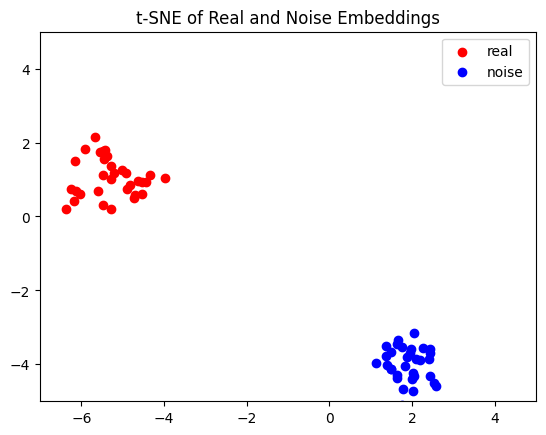

In [8]:
# visualize
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d[:real_embeddings.shape[0], 0], embeddings_2d[:real_embeddings.shape[0], 1], c="red", label="real")
plt.scatter(embeddings_2d[real_embeddings.shape[0]:, 0], embeddings_2d[real_embeddings.shape[0]:, 1], c="blue", label="noise")
plt.legend(loc="upper right")
plt.xlim(-7, 5)
plt.ylim(-5, 5)
plt.title("t-SNE of Real and Noise Embeddings")
plt.show()

## Forward diffusion

In [9]:
def forward_diffusion(x_0, t, noise_schedule, noise=None):
    _ts = t.view(-1, 1, 1, 1)
    if noise is None:
        noise = torch.randn_like(x_0)
    assert _ts.max() < len(noise_schedule["alphas_cumprod"]), f"t={_ts.max()} is larger than the length of noise_schedule: {len(noise_schedule['alphas_cumprod'])}"
    alpha_prod_t = noise_schedule["alphas_cumprod"][_ts]
    x_t = (alpha_prod_t ** 0.5) * x_0 + ((1 - alpha_prod_t) ** 0.5) * noise
    return x_t, noise


In [10]:
from typing import Dict
beta_min, beta_max = 1e-4, 0.02
# beta_min, beta_max = 1e-4, 1
# beta_min, beta_max = 0, 0.02

def create_noise_schedule(n_T: int, device: torch.device) -> Dict[str, torch.Tensor]:
    betas = torch.linspace(beta_min, beta_max, n_T).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), alphas_cumprod[:-1].to(device)])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }

noise_schedule = create_noise_schedule(1000, "cpu")

In [11]:
noised_images = {}
colors = {}
# for t in [0, 50, 100, 200, 300, 500, 800]:
torch.manual_seed(0)
common_noise = torch.randn_like(real_images)
for t in range(0, 1000, 10):
    noised_images[t] = forward_diffusion(real_images.cpu(), torch.tensor([t]), noise_schedule, common_noise)[0]
    alpha_accum = noise_schedule["alphas_cumprod"][t]
    # interpolate between red (1,0,0) and blue (0,0,1)
    #   small alpha_accum is blue, large is red
    colors[t] = (alpha_accum, 0, 1 - alpha_accum)

noised_images[0][0].shape

torch.Size([3, 64, 64])

In [12]:
noised_embeddings = {}
for t in noised_images:
    with torch.no_grad():
        noised_images[t] = resize(noised_images[t])
        features = inception_v3(noised_images[t].to(device))
    noised_embeddings[t] = features.cpu().numpy()


In [67]:
all_embeddings = np.concatenate([real_embeddings, *noised_embeddings.values()], axis=0)
print(f"all_embeddings.shape: {all_embeddings.shape}")
embeddings_2d = tsne.fit_transform(all_embeddings)
real_embeddings_2d = embeddings_2d[:real_embeddings.shape[0]]
# put them back to the original order
noised_embeddings_2d = {}
offset = real_embeddings.shape[0]
for t in noised_embeddings:
    noised_embeddings_2d[t] = embeddings_2d[offset:offset+len(noised_embeddings[t])]
    offset += len(noised_embeddings[t])

# plot the real embeddings
# plt.scatter(real_embeddings_2d[:, 0], real_embeddings_2d[:, 1], c="red", label="real")
# show color gradient from blue to red
trajs = []
for t in noised_embeddings_2d:
    noised_embeddings_this_t_2d = noised_embeddings_2d[t]
    trajs.append(noised_embeddings_this_t_2d)
trajs = np.array(trajs)
color_for_trajs = []
for t in noised_embeddings_2d:
    color_for_trajs.append(colors[t])
color_for_trajs = np.array(color_for_trajs)
print(trajs.shape)

all_embeddings.shape: (3232, 1008)
(100, 32, 2)


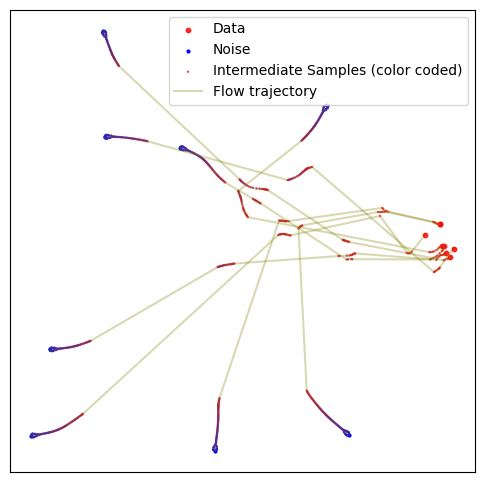

<Figure size 640x480 with 0 Axes>

In [68]:
_ = TrajectorySet(trajs).plot_trajectories(n=8, show_figure=True)

## What about flow matching?

### Flow matching utils

In [26]:
from typing import Union


def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))

class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    - score function $\nabla log p_t(x|x0, x1)$
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """
        Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1 + (1 - t) * x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        standard deviation sigma

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon

    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = x1 - x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t, xt
        return x1 - x0

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], f"t has to have batch size dimension, got {len(t)}"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function, see Eq.(23) [3].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        lambda : score weighting function

        References
        ----------
        [4] Simulation-free Schrodinger bridges via score and flow matching, Preprint, Tong et al.
        """
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)


In [27]:
import numpy as np
import ot as pot
import warnings
from functools import partial

class OTPlanSampler:
    """OTPlanSampler implements sampling coordinates according to an OT plan (wrt squared Euclidean
    cost) with different implementations of the plan calculation."""

    def __init__(
        self,
        method: str,
        reg: float = 0.05,
        reg_m: float = 1.0,
        normalize_cost: bool = False,
        num_threads: Union[int, str] = 1,
        warn: bool = True,
    ) -> None:
        """Initialize the OTPlanSampler class.

        Parameters
        ----------
        method: str
            choose which optimal transport solver you would like to use.
            Currently supported are ["exact", "sinkhorn", "unbalanced",
            "partial"] OT solvers.
        reg: float, optional
            regularization parameter to use for Sinkhorn-based iterative solvers.
        reg_m: float, optional
            regularization weight for unbalanced Sinkhorn-knopp solver.
        normalize_cost: bool, optional
            normalizes the cost matrix so that the maximum cost is 1. Helps
            stabilize Sinkhorn-based solvers. Should not be used in the vast
            majority of cases.
        num_threads: int or str, optional
            number of threads to use for the "exact" OT solver. If "max", uses
            the maximum number of threads.
        warn: bool, optional
            if True, raises a warning if the algorithm does not converge
        """
        # ot_fn should take (a, b, M) as arguments where a, b are marginals and
        # M is a cost matrix
        if method == "exact":
            self.ot_fn = partial(pot.emd, numThreads=num_threads)
        elif method == "sinkhorn":
            self.ot_fn = partial(pot.sinkhorn, reg=reg)
        elif method == "unbalanced":
            self.ot_fn = partial(pot.unbalanced.sinkhorn_knopp_unbalanced, reg=reg, reg_m=reg_m)
        elif method == "partial":
            self.ot_fn = partial(pot.partial.entropic_partial_wasserstein, reg=reg)
        else:
            raise ValueError(f"Unknown method: {method}")
        self.reg = reg
        self.reg_m = reg_m
        self.normalize_cost = normalize_cost
        self.warn = warn

    def get_map(self, x0, x1):
        """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
        minibatch.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch

        Returns
        -------
        p : numpy array, shape (bs, bs)
            represents the OT plan between minibatches
        """
        a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
        if x0.dim() > 2:
            x0 = x0.reshape(x0.shape[0], -1)
        if x1.dim() > 2:
            x1 = x1.reshape(x1.shape[0], -1)
        x1 = x1.reshape(x1.shape[0], -1)
        M = torch.cdist(x0, x1) ** 2
        if self.normalize_cost:
            M = M / M.max()  # should not be normalized when using minibatches
        p = self.ot_fn(a, b, M.detach().cpu().numpy())
        if not np.all(np.isfinite(p)):
            print("ERROR: p is not finite")
            print(p)
            print("Cost mean, max", M.mean(), M.max())
            print(x0, x1)
        if np.abs(p.sum()) < 1e-8:
            if self.warn:
                warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
            p = np.ones_like(p) / p.size
        return p

    def sample_map(self, pi, batch_size, replace=True):
        r"""Draw source and target samples from pi  $(x,z) \sim \pi$

        Parameters
        ----------
        pi : numpy array, shape (bs, bs)
            represents the source minibatch
        batch_size : int
            represents the OT plan between minibatches
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
            represents the indices of source and target data samples from $\pi$
        """
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
        )
        return np.divmod(choices, pi.shape[1])

    def sample_plan(self, x0, x1, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the source minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return x0[i], x1[j]

    def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
        r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
        minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs)
            represents the source label minibatch
        y1 : Tensor, shape (bs)
            represents the target label minibatch
        replace : bool
            represents sampling or without replacement from the OT plan

        Returns
        -------
        x0[i] : Tensor, shape (bs, *dim)
            represents the source minibatch drawn from $\pi$
        x1[j] : Tensor, shape (bs, *dim)
            represents the target minibatch drawn from $\pi$
        y0[i] : Tensor, shape (bs, *dim)
            represents the source label minibatch drawn from $\pi$
        y1[j] : Tensor, shape (bs, *dim)
            represents the target label minibatch drawn from $\pi$
        """
        pi = self.get_map(x0, x1)
        i, j = self.sample_map(pi, x0.shape[0], replace=replace)
        return (
            x0[i],
            x1[j],
            y0[i] if y0 is not None else None,
            y1[j] if y1 is not None else None,
        )

    def sample_trajectory(self, X):
        """Compute the OT trajectories between different sample populations moving from the source
        to the target distribution.

        Parameters
        ----------
        X : Tensor, (bs, times, *dim)
            different populations of samples moving from the source to the target distribution.

        Returns
        -------
        to_return : Tensor, (bs, times, *dim)
            represents the OT sampled trajectories over time.
        """
        times = X.shape[1]
        pis = []
        for t in range(times - 1):
            pis.append(self.get_map(X[:, t], X[:, t + 1]))

        indices = [np.arange(X.shape[0])]
        for pi in pis:
            j = []
            for i in indices[-1]:
                j.append(np.random.choice(pi.shape[1], p=pi[i] / pi[i].sum()))
            indices.append(np.array(j))

        to_return = []
        for t in range(times):
            to_return.append(X[:, t][indices[t]])
        to_return = np.stack(to_return, axis=1)
        return to_return


class ExactOptimalTransportConditionalFlowMatcher(ConditionalFlowMatcher):
    """Child class for optimal transport conditional flow matching method. This class implements
    the OT-CFM methods from [1] and inherits the ConditionalFlowMatcher parent class.

    It overrides the sample_location_and_conditional_flow.
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        ot_sampler: exact OT method to draw couplings (x0, x1) (see Eq.(17) [1]).
        """
        super().__init__(sigma)
        self.ot_sampler = OTPlanSampler(method="exact")

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1 = self.ot_sampler.sample_plan(x0, x1)
        return super().sample_location_and_conditional_flow(x0, x1, t, return_noise)

    def guided_sample_location_and_conditional_flow(
        self, x0, x1, y0=None, y1=None, t=None, return_noise=False
    ):
        r"""
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
        with respect to the minibatch OT plan $\Pi$.

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        y0 : Tensor, shape (bs) (default: None)
            represents the source label minibatch
        y1 : Tensor, shape (bs) (default: None)
            represents the target label minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon

        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        x0, x1, y0, y1 = self.ot_sampler.sample_plan_with_labels(x0, x1, y0, y1)
        if return_noise:
            t, xt, ut, eps = super().sample_location_and_conditional_flow(x0, x1, t, return_noise)
            return t, xt, ut, y0, y1, eps
        else:
            t, xt, ut = super().sample_location_and_conditional_flow(x0, x1, t, return_noise)
            return t, xt, ut, y0, y1

2024-12-02 23:00:43.531809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 23:00:43.543894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:00:43.556582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:00:43.560354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:00:43.569758: I tensorflow/core/platform/cpu_feature_guar

### Visualize flow matching plan

In [40]:
FM = ConditionalFlowMatcher(sigma=0)

In [92]:
from tqdm import tqdm


def generate_trajectories(FM, num_timesteps=10, n=32, seed=0):
    x_clean = real_images[:n]

    # noisy data
    torch.manual_seed(seed)
    x_noisy = torch.randn_like(x_clean)
    # Sample multiple timesteps to visualize flow progression
    t_grid = torch.linspace(0, 1, num_timesteps)
    x_ts = []
    # u_ts = []

    for i, t in enumerate(t_grid):
        t_batch = t.repeat(x_clean.shape[0])
        np.random.seed(seed)
        t, x_t, u_t = FM.sample_location_and_conditional_flow(x0=x_clean, x1=x_noisy, t=t_batch)
        x_ts.append(x_t.detach().cpu().numpy())
        if i == 0:
            print("x_t images mean (t=0):", x_t.mean(), "x_clean images mean:", x_clean.mean())
        if i == len(t_grid) - 1:
            print("x_t images mean (t=1):", x_t.mean(), "x_noisy images mean:", x_noisy.mean())
        # u_ts.append(u_t.detach().cpu().numpy())
    
    # First, extract the embeddings
    print("Extracting embeddings...")
    x_ts_embeddings = []
    resize = transforms.Resize((224, 224))

    def to_tensor(x):
        return torch.from_numpy(x)
    
    inception_v3.eval()
    with torch.no_grad():
        for x_t in tqdm(x_ts):
            x_ts_embeddings.append(inception_v3(resize(to_tensor(x_t).to(device))).cpu().numpy())

    all_x_embeddings = np.array(x_ts_embeddings)
    traj_set = TrajectorySet(all_x_embeddings)
    return traj_set


traj_set = generate_trajectories(FM, num_timesteps=100, n=16)
print("clean data mean:", traj_set.embeddings[0].mean())

x_t images mean (t=0): tensor(-0.2593) x_clean images mean: tensor(-0.2593)
x_t images mean (t=1): tensor(-0.0035) x_noisy images mean: tensor(-0.0035)
Extracting embeddings...


100%|██████████| 100/100 [00:01<00:00, 94.71it/s]

clean data mean: -0.035028137


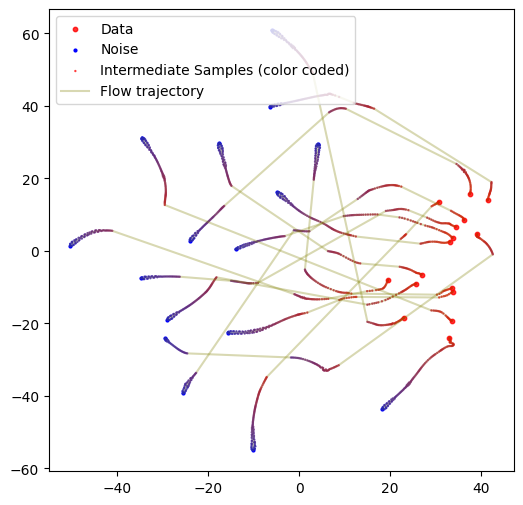

<Figure size 640x480 with 0 Axes>

In [83]:
_ = traj_set.plot_trajectories(n=16, show_figure=True,  with_ticks=True)

In [74]:
FM_ot = ExactOptimalTransportConditionalFlowMatcher(sigma=0)
ot_traj_set = generate_trajectories(FM_ot, num_timesteps=100, n=16)
print("clean data mean:", ot_traj_set.embeddings[0].mean())

Extracting embeddings...


100%|██████████| 100/100 [00:01<00:00, 94.74it/s]

clean data mean: -0.03625052


Running t-SNE on (100, 16, 1008) embeddings...
t-SNE done. Shape of 2D embeddings: (100, 16, 2)


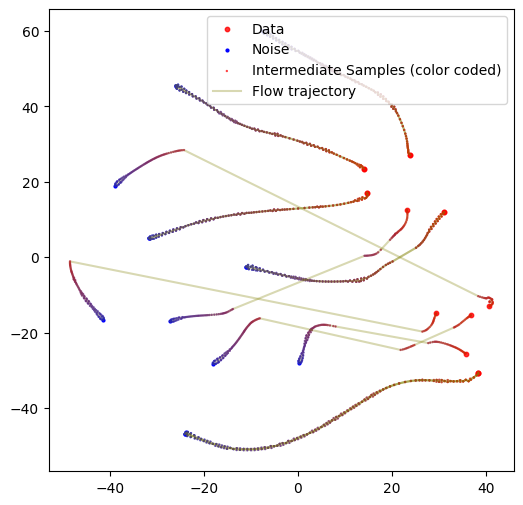

<Figure size 640x480 with 0 Axes>

In [84]:
_ = ot_traj_set.plot_trajectories(n=16, show_figure=True, with_ticks=True)

In [93]:
traj_set = generate_trajectories(FM, num_timesteps=100, n=16)
print("clean embedding mean:", traj_set.embeddings[0].mean())
print("noise embedding mean:", traj_set.embeddings[-1].mean())
ot_traj_set = generate_trajectories(FM_ot, num_timesteps=100, n=16)
print("OT clean embedding mean:", ot_traj_set.embeddings[0].mean())
print("OT noise embedding mean:", ot_traj_set.embeddings[-1].mean())


x_t images mean (t=0): tensor(-0.2593) x_clean images mean: tensor(-0.2593)
x_t images mean (t=1): tensor(-0.0035) x_noisy images mean: tensor(-0.0035)
Extracting embeddings...


100%|██████████| 100/100 [00:01<00:00, 95.40it/s]


clean embedding mean: -0.035028137
noise embedding mean: -0.023954444
x_t images mean (t=0): tensor(-0.1974) x_clean images mean: tensor(-0.2593)
x_t images mean (t=1): tensor(-0.0002) x_noisy images mean: tensor(-0.0035)
Extracting embeddings...


100%|██████████| 100/100 [00:01<00:00, 95.34it/s]

OT clean embedding mean: -0.03625052
OT noise embedding mean: -0.024131157


## Visualize the images in x_t using OT plan


In [111]:
real_images = real_images[:8]
x_clean = real_images
print("x_clean.shape:", x_clean.shape)
torch.manual_seed(0)
x_noisy = torch.randn_like(x_clean)
FM_ot = ExactOptimalTransportConditionalFlowMatcher(sigma=0)
t, x_t, u_t = FM_ot.sample_location_and_conditional_flow(x0=x_clean, x1=x_noisy, t=torch.tensor(0).repeat(x_clean.shape[0]))


x_clean.shape: torch.Size([8, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


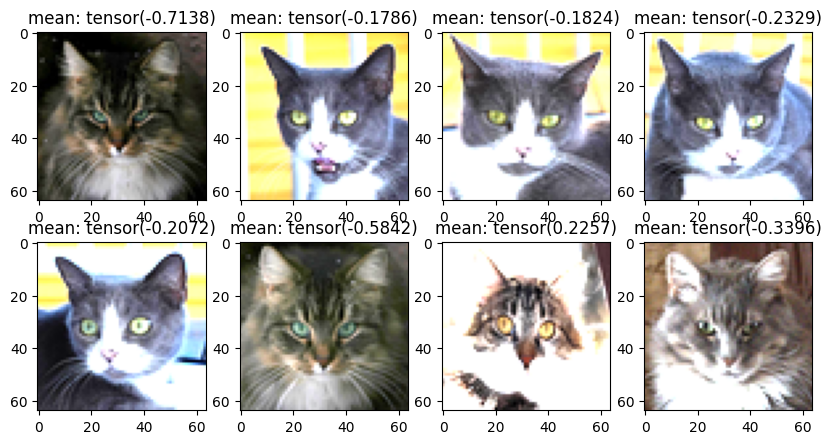

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


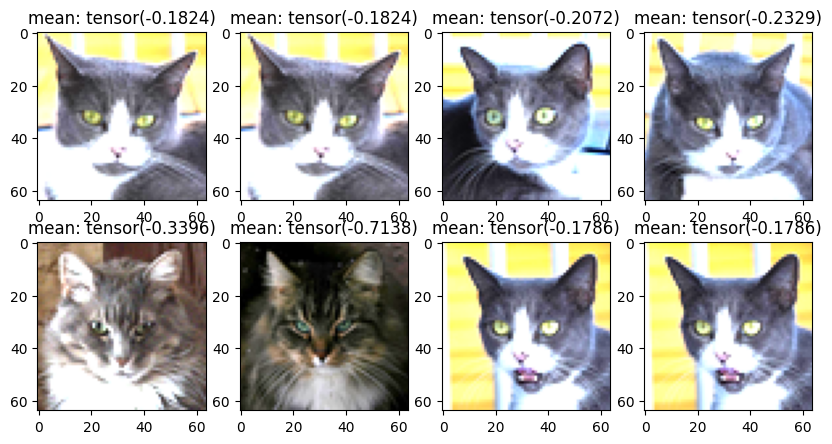

In [113]:
# display x_clean
# Do a subplot with 2 by 4 layout
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(2):
    for j in range(4):  
        axs[i, j].imshow((x_clean[i * 4 + j].permute(1, 2, 0) + 1))
        axs[i, j].set_title("mean: " + str(x_clean[i * 4 + j].mean()))
plt.show()

# display x_t
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(2):
    for j in range(4):
        axs[i, j].imshow((x_t[i * 4 + j].permute(1, 2, 0) + 1))
        axs[i, j].set_title("mean: " + str(x_t[i * 4 + j].mean()))
plt.show()